# Exercie sur dataset EEG 

Approche simple d'un dataset EEG en 4 étapes:

  * Load
  * Visualize
  * Preprocessing
  * Analysis

# Import

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mne
import scipy
import os

# Dataset Simulation

In [34]:
debug = False

# Définition des paramètres
n_channels = 64  # Nombre de canaux EEG
sampling_rate = 250  # Fréquence d'échantillonnage en Hz
duration = 10 * 60  # Durée de l'enregistrement en secondes
n_samples = sampling_rate * duration  # Nombre total d'échantillons
n_triggers = 200  # Nombre total de triggers

# Définition desfreqs canaux EEG
channels = [
    'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8',
    'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8',
    'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8',
    'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8',
    'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8',
    'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8',
    'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz',
    'A1', 'A2']

n_perm = 250

In [59]:

def pink_noise(n_samples, n_channels):

    freqs = np.fft.rfftfreq(n_samples, d=1/sampling_rate) # on génère le vecteur des fréquences
    amplitudes = 1 / (freqs + 1e-10)  # le 1/f pour les amplitudes
    phases = np.random.uniform(0, 2*np.pi, (n_channels, len(freqs))) # les phases aléatoire pour les coefficients de fourier
    spectrum = amplitudes * (np.cos(phases) + 1j * np.sin(phases)) # génération du spectre de fréquence
    noise = np.fft.irfft(spectrum, n_samples) # inverse fft pour récupérer le signal en réel
    noise = scipy.stats.zscore(noise, axis=1) * 1e-6 # Normalisation des données pour avoir des micro volts
    
    if debug:

        plt.plot(freqs)
        plt.show()

        plt.plot(amplitudes)
        plt.show()

        plt.plot(noise[0,:])
        plt.show()

    return noise


def generate_data_set():

    # Génération de la matrice EEG avec du bruit rose
    EEG_data = pink_noise(n_samples, n_channels)

    # Ajout d'un signal 50 Hz avec une certaine amplitude
    f_noise = 50  # Fréquence de l'interférence
    amplitude_50hz = EEG_data.std()/100  # Niveau de l'interférence

    time = np.arange(n_samples) / sampling_rate
    interference = amplitude_50hz * np.sin(2 * np.pi * f_noise * time)

    if debug:

        plt.plot(interference)
        plt.show()

        plot_PSD(interference)

    EEG_data += interference

    if debug:

        plt.plot(EEG_data[0,:sampling_rate*5])
        plt.show()

        plot_PSD(EEG_data[0,:])

    # Génération du vecteur de triggers
    trigger_vector = np.zeros(n_samples)  # Initialisation avec des zéros

    # Génération des indices des triggers (espacés entre 2.5s et 3s)
    trigger_times = np.cumsum(np.random.uniform(2.5, 3, n_triggers))  
    trig_idxs = np.round(trigger_times * sampling_rate).astype(int)  # Conversion en indices

    # Séparation en deux types de triggers
    types = np.concatenate([np.ones((int(len(trig_idxs)/2))), np.ones((int(len(trig_idxs)/2)))+1])
    np.random.shuffle(types)
    trigger_vector[trig_idxs] = types
    trig_type = trigger_vector[trigger_vector != 0]

    # Génération des blinks
    blink_amplitude = 1
    blink_duration = 0.5  # s
    blink_samples = int(blink_duration * sampling_rate)
    blink_waveform = np.exp(-np.linspace(-2, 2, blink_samples)**2)
    blink_weights = np.array([1.0 if ch in ['Fp1', 'Fp2', 'F3', 'F4'] else 0.1 for ch in channels])

    blink_times = np.cumsum(np.random.uniform(0, 12, int(n_triggers/2)))  # Temps des blinks
    blink_idxs = np.round(blink_times * sampling_rate).astype(int)

    blink_sig = np.zeros((n_samples))

    for idx in blink_idxs:
        if idx + blink_samples < n_samples:
            blink_sig[idx:idx + blink_samples] = blink_waveform * blink_amplitude

    blink_sig *= EEG_data.std() # on scale le signal, plus important que pour le reste

    if debug:

        plt.plot(blink_sig)
        plt.show()

    # On ajoute le signal
    for ch_i, ch in enumerate(channels):

        EEG_data[ch_i,:] += blink_sig * blink_weights[ch_i]

    if debug:

        plt.plot(EEG_data[0,:])
        plt.show()

        plt.plot(EEG_data[-1,:])
        plt.show()

    # Génération des activités P1 et N1
    p1_amplitude = 0.5
    n1_amplitude = -0.4
    erp_duration = 0.3  # 100 ms
    p1_samples = n1_samples = int(erp_duration * sampling_rate)

    p1_waveform = p1_amplitude * np.exp(-np.linspace(-2, 2, p1_samples)**2)
    n1_waveform = n1_amplitude * np.exp(-np.linspace(-2, 2, n1_samples)**2)

    if debug:

        plt.plot(p1_waveform)
        plt.show()

        plt.plot(n1_waveform)
        plt.show()

    erp_weights = np.array([1.0 if ch in ['T7', 'T8'] else 0.7 if ch in ['Cz', 'P3', 'Pz', 'P4'] else 0 for ch in channels])

    erp_sig = np.zeros((n_samples))

    for idx, t in zip(trig_idxs, types):
        factor = 1 if t == 1 else 0.5  # Réduction de l'amplitude pour trigger 2
        p1_idx = idx + int(0.1 * sampling_rate)  # 600ms après trigger
        n1_idx = idx + int(0.6 * sampling_rate)  # 700ms après trigger
        if p1_idx + p1_samples < n_samples:
            erp_sig[p1_idx:p1_idx + p1_samples] = p1_waveform * factor
        if n1_idx + n1_samples < n_samples:
            erp_sig[n1_idx:n1_idx + n1_samples] = n1_waveform * factor

    erp_sig *= EEG_data.std()/5 # on scale le signal

    if debug:

        plt.plot(erp_sig)
        plt.show()

    # On ajoute le signal
    for ch_i, ch in enumerate(channels):

        EEG_data[ch_i,:] += erp_sig * erp_weights[ch_i]

    if debug:

        plt.plot(EEG_data[0,:])
        plt.show()

    # Génération des activités Theta et Gamma
    theta_duration = 0.800  # 500 ms
    gamma_duration = 0.100  # 150 ms
    theta_samples = int(theta_duration * sampling_rate)
    gamma_samples = int(gamma_duration * sampling_rate)
    theta_freq = 8  # Fréquence centrale de l'onde Theta
    gamma_freq = 60  # Fréquence centrale de l'onde Gamma

    theta_waveform = np.exp(-np.linspace(-2, 2, theta_samples)**2) * np.sin(2 * np.pi * theta_freq * np.linspace(0, theta_duration, theta_samples))
    gamma_waveform = np.exp(-np.linspace(-2, 2, gamma_samples)**2) * np.sin(2 * np.pi * gamma_freq * np.linspace(0, gamma_duration, gamma_samples))

    jitter = 0.3*sampling_rate

    # Gamma
    freq_weights = np.array([1.0 if ch in ['T7', 'T8'] else 0.7 if ch in ['Fp1', 'Fp2'] else 0 for ch in channels])

    freq_sig = np.zeros((n_samples))

    jitter_list = np.array([np.random.randint(low=trig_i-jitter, high=trig_i+jitter, size=1)[0] for trig_i in trig_idxs])

    for idx, t in zip(jitter_list, types):
        factor = 1 if t == 1 else 0.5  # Réduction de l'amplitude pour trigger 2
        gamma_idx = idx + int(0.1 * sampling_rate)  # 500ms après trigger
        if gamma_idx + gamma_samples < n_samples:
            freq_sig[gamma_idx:gamma_idx + gamma_samples] = gamma_waveform * factor

    freq_sig *= EEG_data.std()/50 # on scale le signal

    if debug:

        plt.plot(freq_sig)
        plt.show()

    for ch_i, ch in enumerate(channels):

        EEG_data[ch_i,:] += freq_sig * freq_weights[ch_i]

    # Theta
    freq_sig = np.zeros((n_samples))

    freq_weights = np.array([1.0 if ch in ['T7', 'T8'] else 0.7 if ch in ['Fp1', 'Fp2'] else 0 for ch in channels])

    jitter_list = np.array([np.random.randint(low=trig_i-jitter, high=trig_i+jitter, size=1)[0] for trig_i in trig_idxs])

    for idx, t in zip(jitter_list, types):
        factor = 1 if t == 1 else 0.5  # Réduction de l'amplitude pour trigger 2
        theta_idx = idx + int(0.2 * sampling_rate)  # 600ms après trigger
        if theta_idx + theta_samples < n_samples:
            freq_sig[theta_idx:theta_idx + theta_samples] = theta_waveform * factor

    freq_sig *= EEG_data.std()/10 # on scale le signal

    if debug:

        plt.plot(freq_sig)
        plt.show()

    # On ajoute le signal
    for ch_i, ch in enumerate(channels):

        EEG_data[ch_i,:] += freq_sig * freq_weights[ch_i]

    trig_idxs = trig_idxs.astype('int')
    trig_type = trig_type.astype('int')

    if debug:

        plt.plot(EEG_data[-1,:])
        plt.show()

    return EEG_data, trig_idxs, trig_type




def plot_PSD(x):

    hzPxx, Pxx = scipy.signal.welch(x, fs=sampling_rate, window='hann', nperseg=sampling_rate*20, noverlap=sampling_rate*20/2, nfft=None)
    plt.figure()
    plt.plot(hzPxx, Pxx)
    plt.yscale('log')
    plt.show()

# to compare during preprocessing
#data_pre, data_post, srate, chan_name = EEG_data, raw.get_data(), sampling_rate, 'Fp1'
def compare_pre_post(data_pre, data_post, srate, chan_name):

    # compare before after
    nchan_i = channels.index(chan_name)
    x_pre = data_pre[nchan_i,:]
    x_post = data_post[nchan_i,:]
    time = np.arange(x_pre.shape[0]) / srate

    nwind = int(10*srate)
    nfft = nwind
    noverlap = np.round(nwind/2)
    hannw = scipy.signal.windows.hann(nwind)

    hzPxx, Pxx_pre = scipy.signal.welch(x_pre,fs=srate,window=hannw,nperseg=nwind,noverlap=noverlap,nfft=nfft)
    hzPxx, Pxx_post = scipy.signal.welch(x_post,fs=srate,window=hannw,nperseg=nwind,noverlap=noverlap,nfft=nfft)

    plt.figure()
    plt.plot(time, x_pre, label='x_pre')
    plt.plot(time, x_post, label='x_post')
    plt.title(chan_name)
    plt.legend()
    plt.show()

    plt.figure()
    plt.semilogy(hzPxx, Pxx_pre, label='Pxx_pre')
    plt.semilogy(hzPxx, Pxx_post, label='Pxx_post')
    plt.title(chan_name)
    plt.legend()
    # plt.xlim(60,360)
    plt.show()



# Export data

In [60]:
EEG_data, trig_idxs, trig_type = generate_data_set()

# info object
ch_types = ['eeg'] * len(channels)
info = mne.create_info(ch_names=channels, sfreq=sampling_rate, ch_types=ch_types)
info.set_montage('standard_1020')

# raw object
raw = mne.io.RawArray(EEG_data, info)

# events object
events = np.column_stack((trig_idxs,np.zeros(len(trig_idxs), dtype=int),trig_type)).astype(int)
event_dict = {1: 'Stimulus/1', 2: 'Stimulus/2'}
annotations = mne.annotations_from_events(events, sfreq=sampling_rate, event_desc=event_dict)
raw.set_annotations(annotations)

# mkdir
if not os.path.exists("eeg_data"):
    os.makedirs("eeg_data")

# save to .fif
exportpath = os.path.join(os.getcwd(), "eeg_data", "eeg_data_raw.fif")
raw.save(exportpath, overwrite=True)

Creating RawArray with float64 data, n_channels=64, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   599.996 secs
Ready.
Writing c:\Users\jules\Downloads\eeg_data\eeg_data_raw.fif
Closing c:\Users\jules\Downloads\eeg_data\eeg_data_raw.fif
[done]


[WindowsPath('c:/Users/jules/Downloads/eeg_data/eeg_data_raw.fif')]

# 1) Load

* chargez le dataset
* extrayez les infos suivantes : Durée, Fréquence d échantillonnage, Nombre de channels, Événements détectés

In [76]:
importpath = os.path.join(os.getcwd(), "eeg_data", "eeg_data_raw.fif")
raw = mne.io.read_raw_fif(importpath, preload=True)

print(f"Durée (s)         : {raw.times[-1]:.2f}")
print(f"Fréquence d échantillonnage : {raw.info['sfreq']} Hz")
print(f"Nombre d échantillons : {raw.n_times}")
print(f"Nombre de channels  : {raw.info['nchan']}")

channel_names = raw.info['ch_names']
print(channel_names)

if raw.annotations:
    print(raw.annotations)
else:
    print("Aucune annotation trouvée.")

events, event_id = mne.events_from_annotations(raw)
print(f"Événements détectés : {len(events)}")
print("Liste des types d’événements :")
print(event_id)


Opening raw data file c:\Users\jules\Downloads\eeg_data\eeg_data_raw.fif...
    Range : 0 ... 149999 =      0.000 ...   599.996 secs
Ready.
Reading 0 ... 149999  =      0.000 ...   599.996 secs...
Durée (s)         : 600.00
Fréquence d échantillonnage : 250.0 Hz
Nombre d échantillons : 150000
Nombre de channels  : 64
['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz', 'A1', 'A2']
<Annotations | 200 segments: Stimulus/1 (100), Stimulus/2 (100)>
Used Annotations descriptions: [np.str_('Stimulus/1'), np.str_('Stimulus/2')]
Événements détectés : 200
Liste des types d’événements :
{np.str_('Stimulus/1'): 1, np.str_('Stimulus/2'): 2}


# 2) Visualize data
* visualisez le montage EEG
* inspectez les données

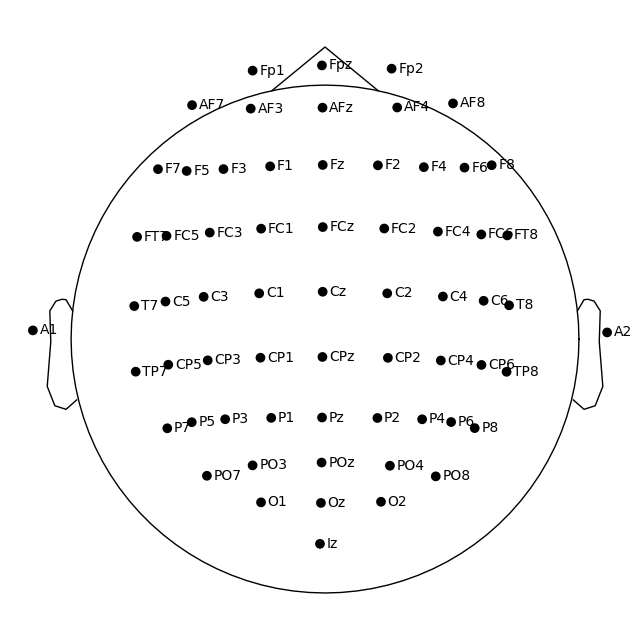

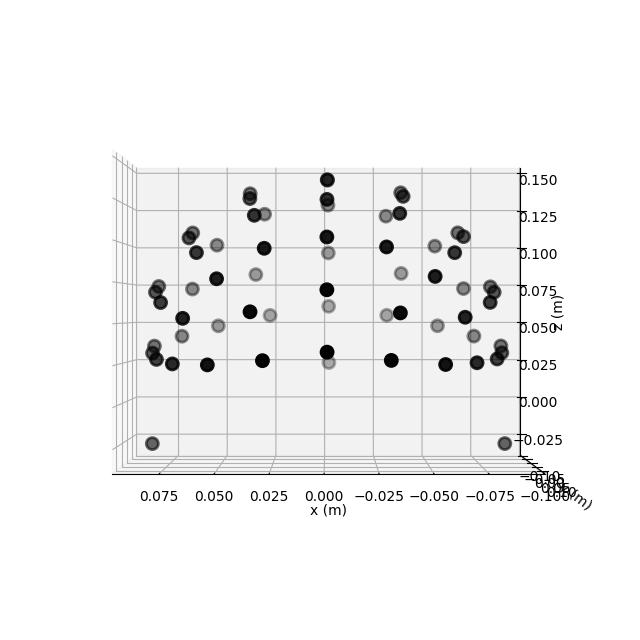

In [62]:
#Channel locations
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors("3d")

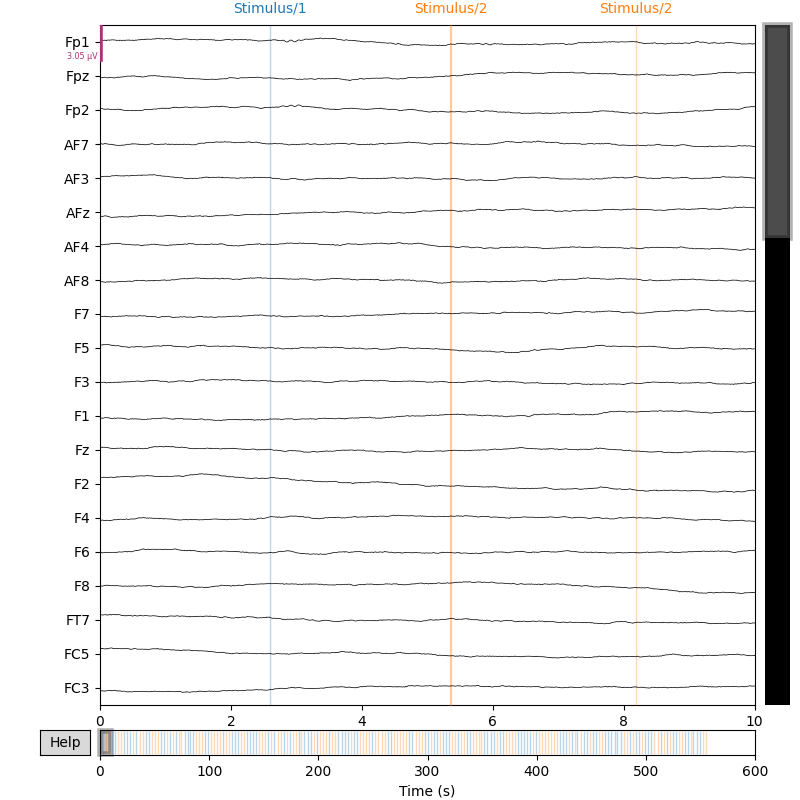

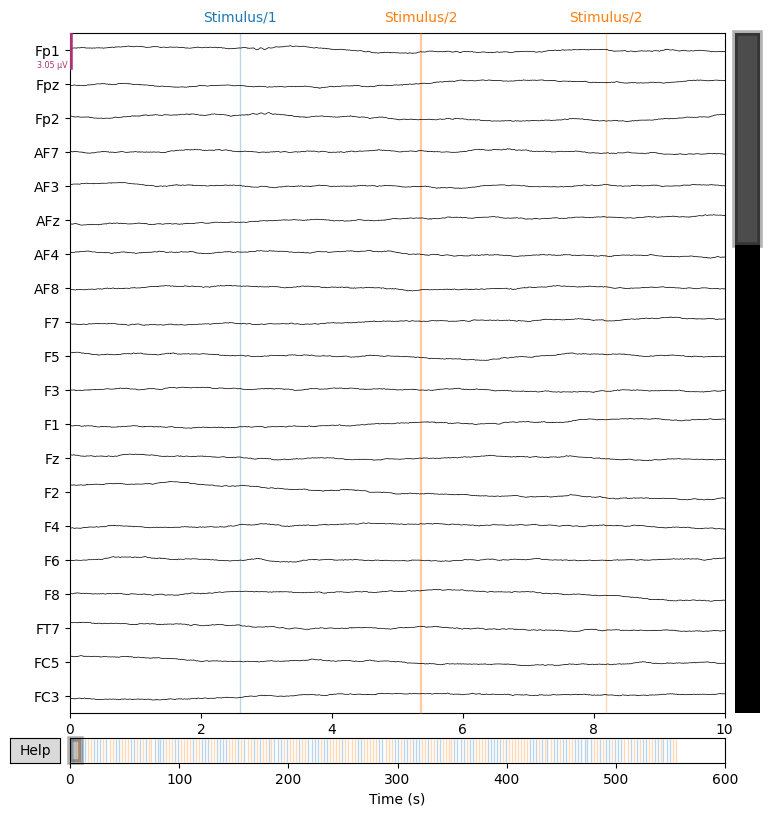

In [63]:
raw.plot(title="EEG with Annotations", duration=10, n_channels=20, scalings='auto')

# 3) Preprocessing

* appliquez un passe bas à 80Hz
* appliquez un notch à 50Hz
* corrigez les blinks

In [64]:
raw.filter(l_freq=1, h_freq=None)  # Filtre passe-haut (1 Hz pour supprimer la dérive)
raw.notch_filter(freqs=[50], notch_widths=1)  # Filtre Notch pour le 50 Hz

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 48.75 Hz)
- Upper passband edge: 51.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 51.25 Hz)
- Filter length: 1651 samples

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Raw | eeg_data_raw.fif, 64 x 150000 (600.0 s), ~73.3 MiB, data loaded>

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 14.7s.
Creating RawArray with float64 data, n_channels=10, n_times=150000
    Range : 0 ... 149999 =      0.000 ...   599.996 secs
Ready.


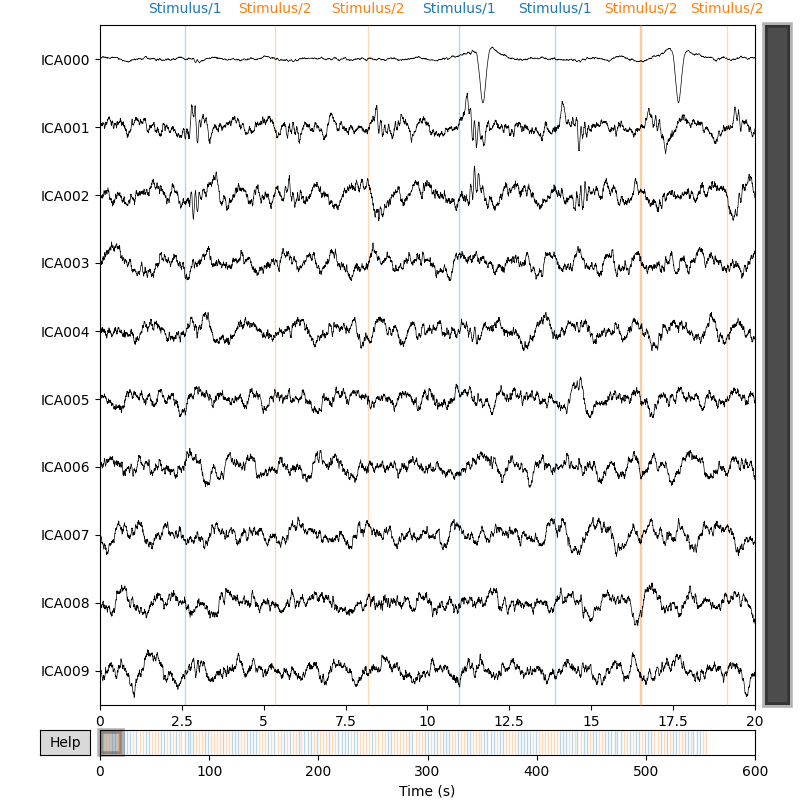

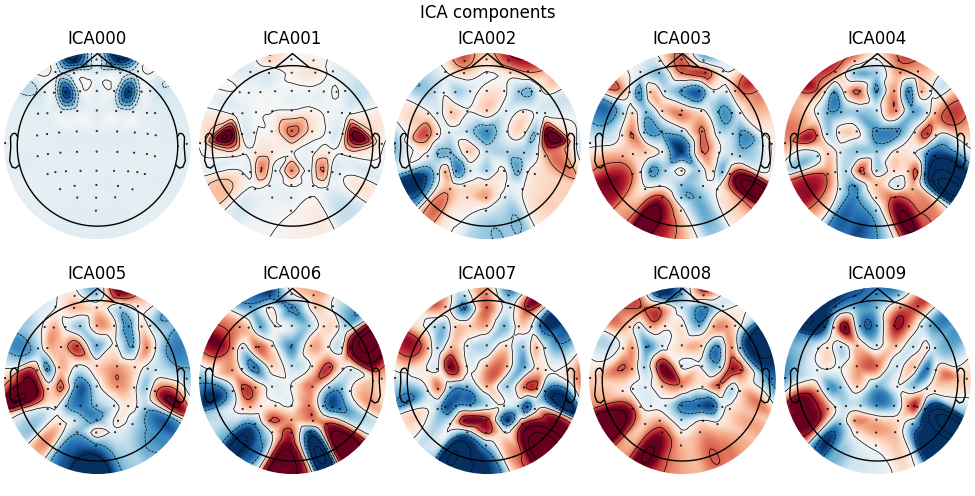

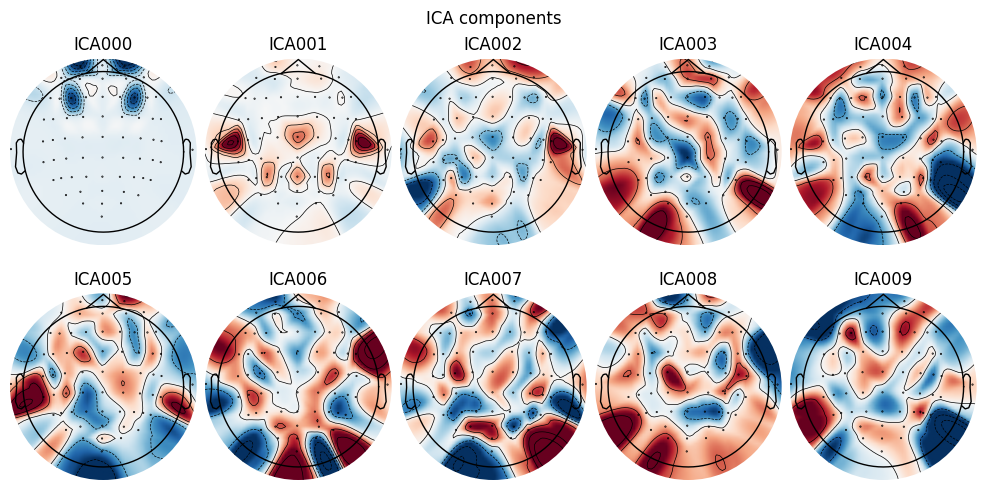

In [65]:
ica = mne.preprocessing.ICA(n_components=10, random_state=42, method="fastica")
ica.fit(raw)

ica.plot_sources(raw)
ica.plot_components()

In [66]:
ica.apply(raw) # exclude component

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


<Raw | eeg_data_raw.fif, 64 x 150000 (600.0 s), ~73.3 MiB, data loaded>

# 4) Analyses
* Identifiez une activitée ERP dans les signaux
* Exportez dans un dossier les résultats ERP les figures pertinentes
* Identifiez une activitée TF dans les signaux
* Exportez dans un dossier les résultats TF les figures pertinentes

Used Annotations descriptions: [np.str_('Stimulus/1'), np.str_('Stimulus/2')]
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 501 original time points ...
0 bad epochs dropped


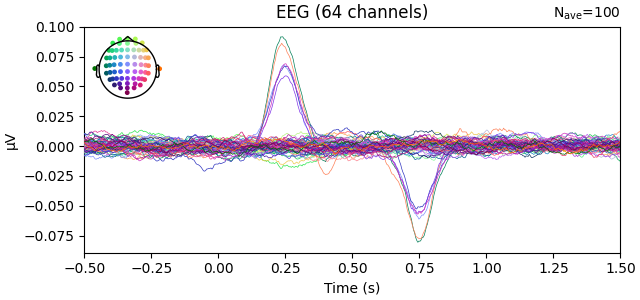

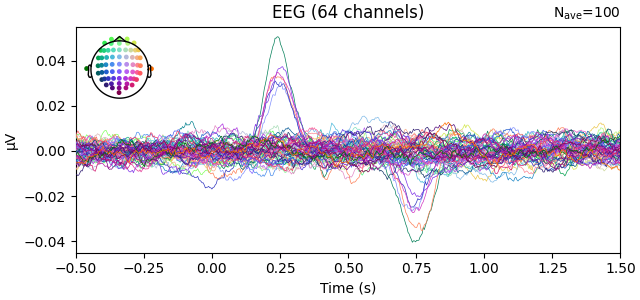

In [67]:
epochs = mne.Epochs(raw, tmin=-0.5, tmax=1.5, baseline=None, detrend=1, preload=True)
erp_1 = epochs["1"].average()
erp_2 = epochs["2"].average()

fig1 = erp_1.plot(window_title = "1")
fig2 = erp_2.plot(spatial_colors=True, window_title = "2")

No projector specified for this dataset. Please consider the method self.add_proj.


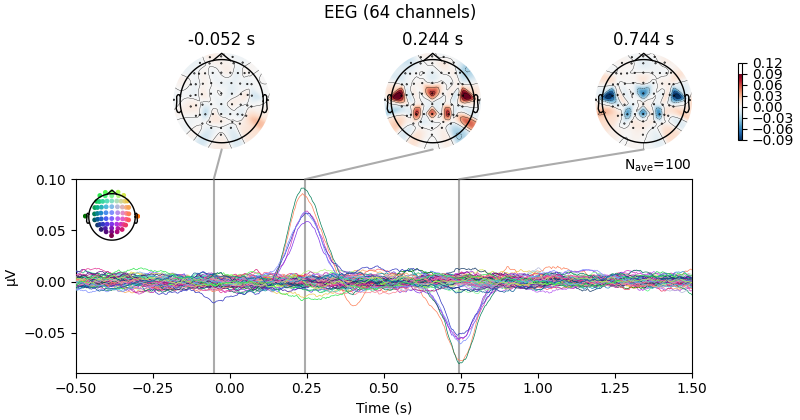

No projector specified for this dataset. Please consider the method self.add_proj.


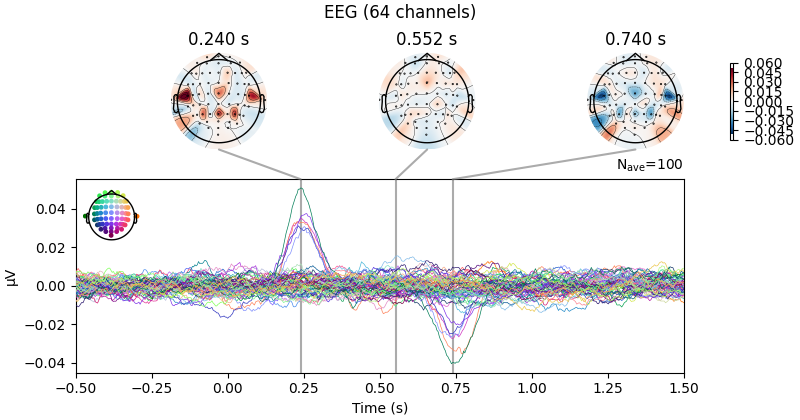

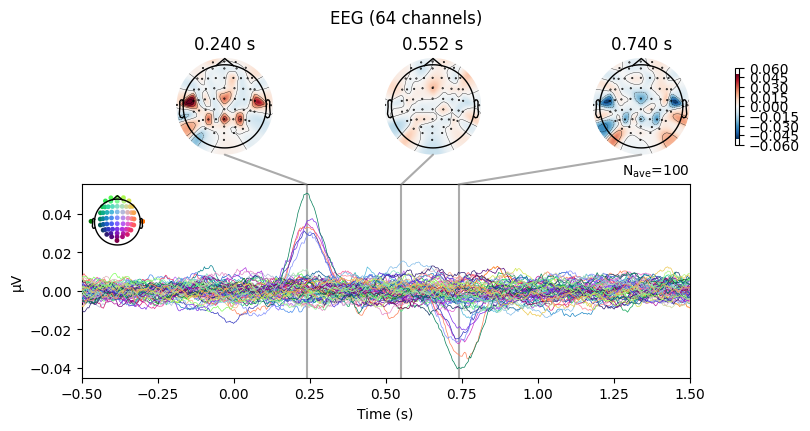

In [68]:
erp_1.plot_joint()
erp_2.plot_joint()

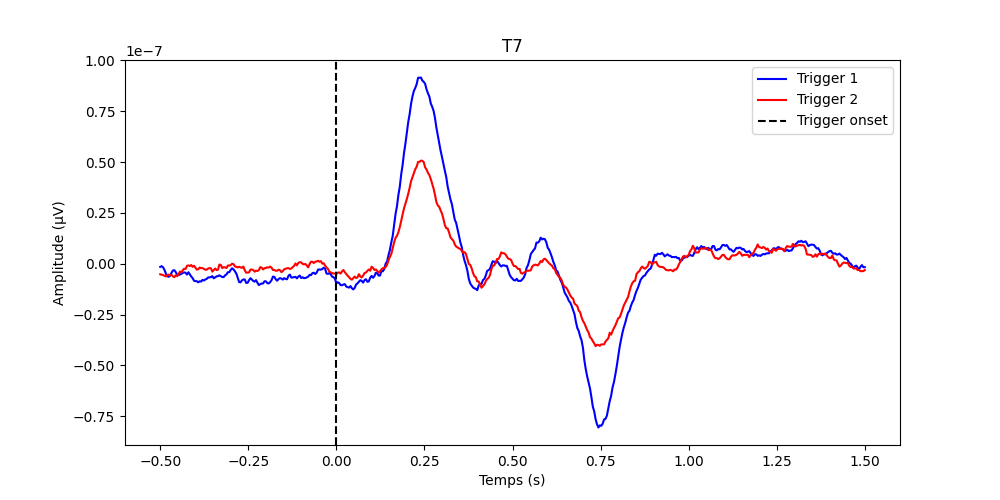

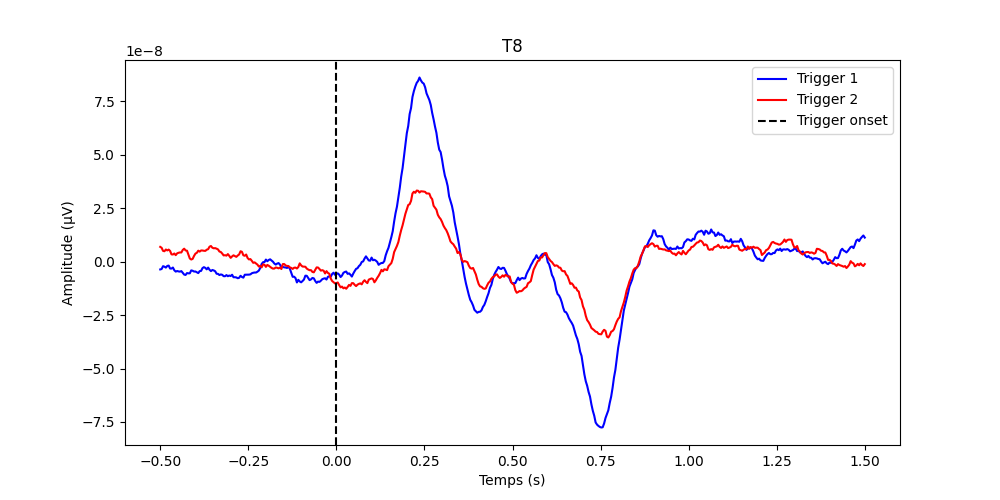

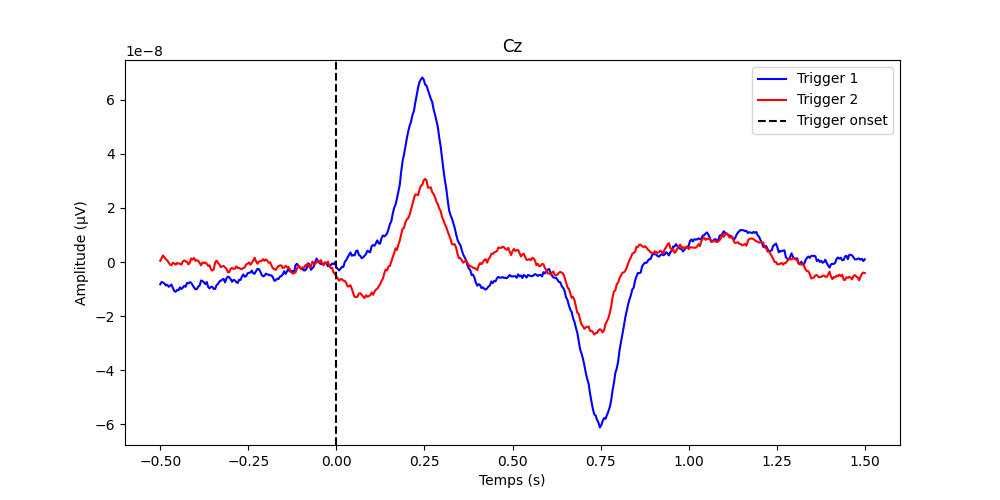

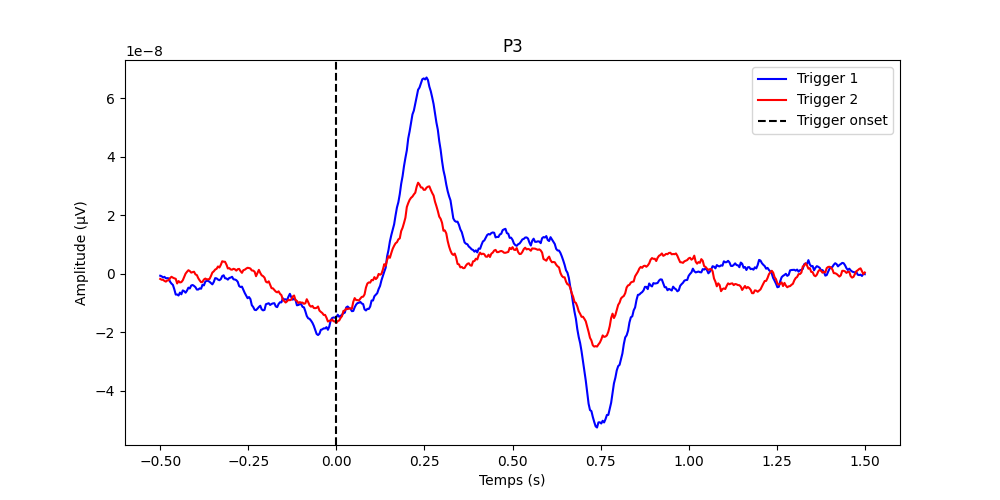

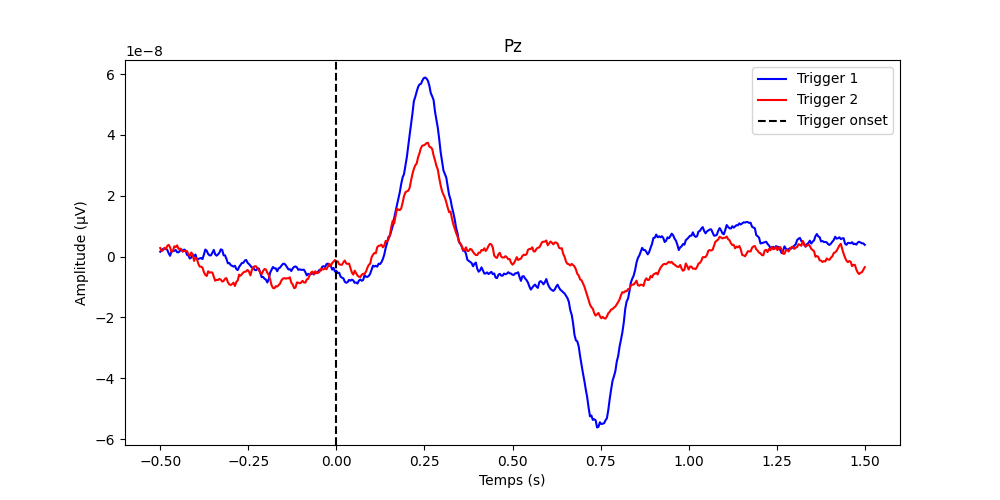

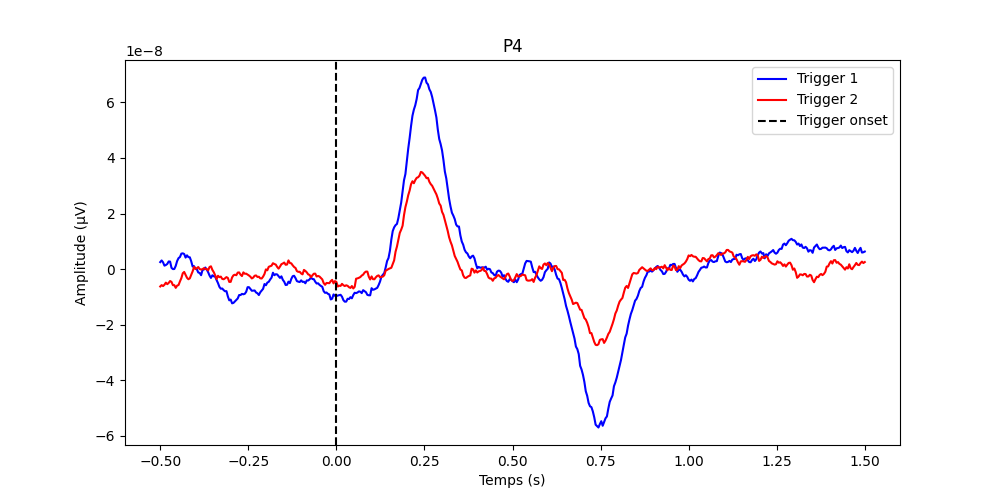

In [69]:
for ch in ['T7', 'T8', 'Cz', 'P3', 'Pz', 'P4']:

    # Tracer la différence ERP sur un canal
    times = erp_1.times
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(times, erp_1.data[channels.index(ch)], label="Trigger 1", color='blue')
    ax.plot(times, erp_2.data[channels.index(ch)], label="Trigger 2", color='red')
    ax.axvline(0, linestyle="--", color="black", label="Trigger onset")

    plt.legend()
    plt.title(f"{ch}")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude (µV)")
    plt.show(block=True)

In [78]:
output_dir = 'results'
os.makedirs(output_dir, exist_ok=True)

for ch in ['T7', 'T8', 'Cz', 'P3', 'Pz', 'P4']:  # Remplace par ta vraie liste de canaux
    times = erp_1.times
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(times, erp_1.data[channels.index(ch)], label="Trigger 1", color='blue')
    ax.plot(times, erp_2.data[channels.index(ch)], label="Trigger 2", color='red')
    ax.axvline(0, linestyle="--", color="black", label="Trigger onset")

    plt.legend()
    plt.title(f"{ch}")
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude (µV)")

    # Sauvegarde au format JPEG
    fig_path = os.path.join(output_dir, f"{ch}_erp.jpeg")
    plt.savefig(fig_path, format='jpeg', dpi=300, bbox_inches='tight')
    plt.close(fig)

In [70]:
trig = 1
events = np.column_stack((trig_idxs[trig_type == trig], np.zeros(len(trig_idxs[trig_type == trig]), dtype=int), trig_type[trig_type == trig]))
epochs_1 = mne.Epochs(raw, events, tmin=-0.5, tmax=1.5, baseline=None, detrend=1, preload=True)
erp_1 = epochs_1.average()

trig = 2
events = np.column_stack((trig_idxs[trig_type == trig], np.zeros(len(trig_idxs[trig_type == trig]), dtype=int), trig_type[trig_type == trig]))
epochs_2 = mne.Epochs(raw, events, tmin=-0.5, tmax=1.5, baseline=None, detrend=1, preload=True)
erp_2 = epochs_2.average()

decim = 2
freqs = np.arange(4, 120, 2)  # define frequencies of interest
n_cycles = np.linspace(4, 21, freqs.size)
tfr_kwargs = dict(
    method="morlet",
    freqs=freqs,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=False,
    average=False,
)

tfr_epochs_1 = epochs_1.compute_tfr(**tfr_kwargs)
tfr_epochs_2 = epochs_2.compute_tfr(**tfr_kwargs)

tfr_epochs_1.apply_baseline(mode="ratio", baseline=(None, 0))
tfr_epochs_2.apply_baseline(mode="ratio", baseline=(None, 0))

Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 100 events and 501 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.5s


Applying baseline correction (mode: ratio)
Applying baseline correction (mode: ratio)


<Power Estimates from Epochs, morlet method | 100 epochs × 64 channels × 58 freqs × 251 times, 4.0 - 118.0 Hz, -0.50 - 1.50 s, 710.9 MiB>

stat_fun(H1): min=-4.1743857042959585 max=6.576569872203388
Running initial clustering …
Found 0 clusters


C:\Users\jules\AppData\Local\Temp\ipykernel_29016\4268605321.py:8: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(


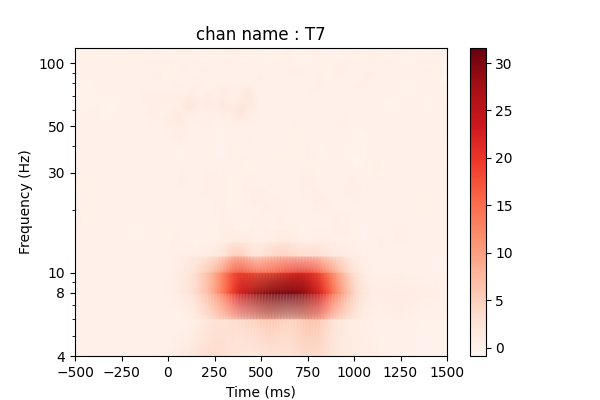

stat_fun(H1): min=-2.7320019107835587 max=5.676600578099129
Running initial clustering …
Found 0 clusters


C:\Users\jules\AppData\Local\Temp\ipykernel_29016\4268605321.py:8: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(


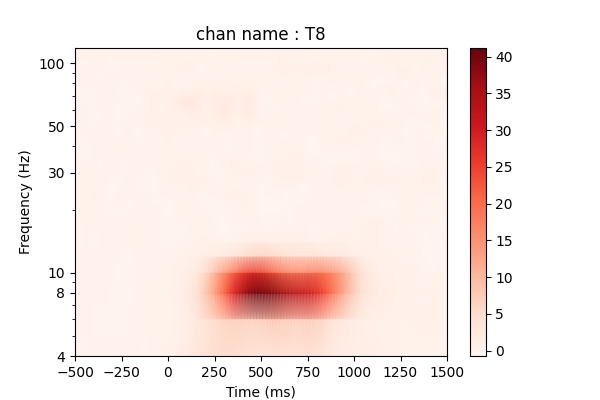

stat_fun(H1): min=-3.3477763972977046 max=5.922851215611618
Running initial clustering …
Found 0 clusters


C:\Users\jules\AppData\Local\Temp\ipykernel_29016\4268605321.py:8: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(


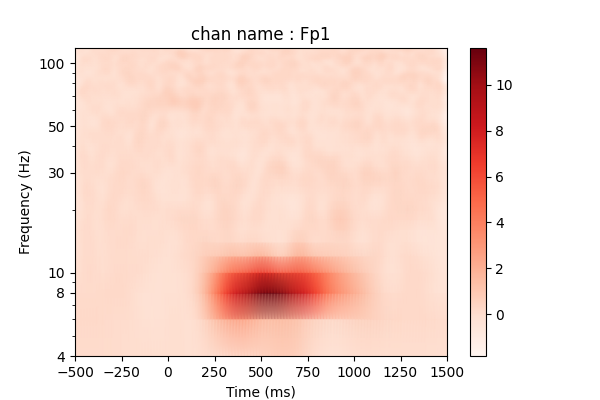

stat_fun(H1): min=-3.5860509369732023 max=6.604339624819384
Running initial clustering …
Found 0 clusters


C:\Users\jules\AppData\Local\Temp\ipykernel_29016\4268605321.py:8: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  F_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_1samp_test(


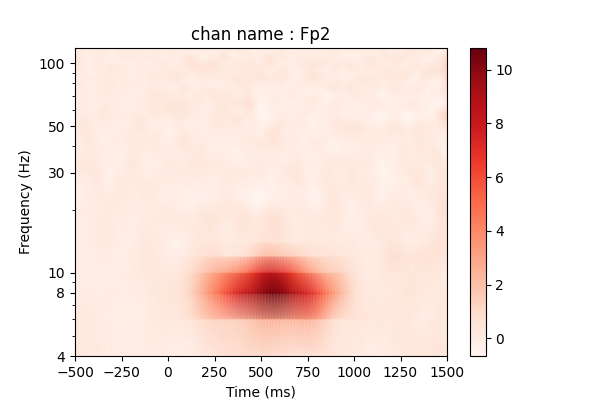

In [ ]:
for ch in ['T7', 'T8', 'Fp1', 'Fp2']:

    ch_i = channels.index(ch)  # get channel index

    epochs_power_1 = tfr_epochs_1.data[:, ch_i, :, :]  # only 1 channel as 3D matrix
    epochs_power_2 = tfr_epochs_2.data[:, ch_i, :, :]  # only 1 channel as 3D matrix
    
    times = 1e3 * tfr_epochs_1.times  # change unit to ms

    # Compute the difference in evoked to determine which was greater since
    # we used a 1-way ANOVA which tested for a difference in population means
    evoked_power_1 = epochs_power_1.mean(axis=0)
    evoked_power_2 = epochs_power_2.mean(axis=0)
    evoked_power_contrast = evoked_power_1 - evoked_power_2


    fig, ax = plt.subplots(figsize=(6, 4))

    im = ax.pcolormesh(times, freqs, evoked_power_contrast, shading='gouraud', cmap=plt.get_cmap('Reds'))

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(f"chan name : {ch}")

    ax.set_yscale('log')

    ax.set_yticks([4,8,10,30,50,100,120], labels=[4,8,10,30,50,100,120])
    ax.set_ylim(freqs[0], freqs[-1])

    fig.colorbar(im, ax=ax)

    plt.show(block=True)

In [73]:
output_dir = 'results'
os.makedirs(output_dir, exist_ok=True)

for ch in ['T7', 'T8', 'Fp1', 'Fp2']:  # Remplace par ta vraie liste de canaux
    fig, ax = plt.subplots(figsize=(6, 4))

    im = ax.pcolormesh(times, freqs, evoked_power_contrast, shading='gouraud', cmap='Reds')

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(f"chan name : {ch}")

    ax.set_yscale('log')
    ax.set_yticks([4, 8, 10, 30, 50, 100, 120], labels=[4, 8, 10, 30, 50, 100, 120])
    ax.set_ylim(freqs[0], freqs[-1])

    fig.colorbar(im, ax=ax)

    # Sauvegarde au format JPEG
    fig_path = os.path.join(output_dir, f"{ch}_tfr.jpeg")
    plt.savefig(fig_path, format='jpeg', dpi=300, bbox_inches='tight')
    plt.close(fig)